In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
import  matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_absolute_percentage_error
import random
import torch
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=521)

In [2]:
train= pd.read_excel('../dataset/pre_train.xlsx')
test= pd.read_excel('../dataset/pre_test.xlsx')


In [3]:
train.shape

(14208, 18)

In [4]:
train.describe()

,WI_F,WI_T,WI_COD,WI_TN,WI_AN,WO_F,WO_T,WO_COD,WO_TN,WO_AN,AR_MLSS,AR_AN,AR_NN,AR_WIDO,AR_WODO,AR_F,AQ
count,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000
mean,1683.382025,27.813829,184.842024,35.791522,27.364368,1547.411837,28.250495,6.228537,10.069905,0.031830,5969.336794,0.201977,8.043728,0.382990,1.282218,4399.123510,14320.010701
std,523.260353,1.013008,55.271241,6.002742,5.126412,598.330524,1.290882,1.677227,1.608902,0.110762,228.335802,0.006275,1.632819,0.117482,0.700147,18.567990,3768.076988
min,217.916363,24.517528,86.577400,17.430883,11.997580,47.077030,25.850362,1.093400,0.881280,0.001093,5273.518511,0.186971,2.419740,0.002295,0.248452,4352.285757,3293.049760
25%,1199.022153,26.990108,146.412000,31.998785,23.677716,1139.269904,27.006044,5.522000,8.979977,0.010757,5816.183677,0.197306,7.056788,0.300399,0.786313,4383.718223,11785.515967
50%,1793.830473,27.918017,170.347500,36.298490,28.359787,1531.360528,28.679910,6.432000,10.122684,0.015721,5967.349452,0.202002,8.196378,0.385052,1.111968,4398.890688,13894.344580
75%,2127.908596,28.646956,213.671800,39.623632,31.143964,1958.713239,29.467961,7.256200,11.203871,0.029753,6112.247880,0.206661,9.218385,0.465928,1.596545,4414.653484,16011.438310
max,3259.585664,30.095026,396.867000,69.558763,37.038204,3320.082757,30.162999,18.309200,13.514503,1.476282,6731.656344,0.216031,14.374467,0.937521,4.745541,4441.656493,31900.870400


In [5]:
ind=[i for i in train.columns][1:-1]
# ind=['WI_F',
#  'WI_T',
#  'WI_COD',
#  'WI_TN',
#  'WI_AN',
#  'WO_F',
#  'WO_T',
#  'WO_COD',
#  'WO_TN',
#  'WO_AN',
#  'AR_MLSS',
#  'AR_AN',
#  'AR_NN',
#  'AR_WIDO',
#  'AR_WODO',
#  'AR_F']
#1  离群点删除
def opt(opt_rate,df,threshold):
    AQindex=[]
    train=df
    threshold_num=threshold*len(df)
    for inx in ind:
        max=train.loc[:, inx].max()
        min=train.loc[:, inx].min()
        diff=max-min
        diffmin=min+opt_rate*diff
        diffmax=min+(1-opt_rate)*diff
        minlist=train[train[inx] < diffmin].index.values.tolist()
        maxlist=train[train[inx] > diffmax].index.values.tolist()

        if len(minlist) <= threshold_num:
            # print(f'min{inx}')
            # print(len(minlist))
            for minindex in train[train[inx] < diffmin].index.values.tolist():
                AQindex.append(minindex)

        if len(maxlist) <= threshold_num:
            # print(f'max{inx}')
            # print(len(maxlist))
            for maxindex in train[train[inx] > diffmax].index.values.tolist():
                AQindex.append(maxindex)
    AQindex=list(set(AQindex))
    # print(AQindex)
    AQindex=sorted(AQindex)
    return AQindex
optindex=opt(opt_rate=0.1,df=train,threshold=0.015)
train=train.drop(index=optindex).reset_index(drop=True)


In [6]:
train.shape
# train.describe()

(12712, 18)

In [7]:
data = pd.concat([train,test]).reset_index(drop=True)

In [8]:
#2  时间特征
def add_datetime_feats(df):
    df['time'] = pd.to_datetime(df['time'])
    # df['year']=df['year'].dt.year  # 获取年
    # df['month']=df['month'].dt.month  # 获取月
    # df['day'] = df['time'].dt.day       # 获取天
    df['hour'] = df['time'].dt.hour
    df['minute']=df['time'].dt.minute  # 获取分钟
    df['weekday']=df['time'].dt.weekday
    df['ts']=df['hour']*60+df['minute']  # 判断是一年的第几个季度
    return df


data= add_datetime_feats(data)


In [10]:
#3 去除率指标
data['Var_COD']=data['WI_COD']-data['WO_COD']
data['Var_AN']=(data['WI_AN']-data['WO_AN'])
data['Var_TN']=(data['WI_TN']-data['WO_TN'])
data['Var_AR_DO']=data['AR_WODO']-data['AR_WIDO']
data['Var_AR_AN']=(data['WI_AN']-data['AR_AN'])


data['RM_COD']=(data['WI_COD']-data['WO_COD'])/data['WI_COD']
data['RM_AN']=(data['WI_AN']-data['WO_AN'])/data['WI_AN']
data['RM_TN']=(data['WI_TN']-data['WO_TN'])/data['WI_TN']
data['RM_AR_DO']=(data['AR_WODO']-data['AR_WIDO'])/data['AR_WODO']
data['RM_AR_AN']=(data['WI_AN']-data['AR_AN'])/data['WI_AN']


In [12]:
#4 时序上的滚动特征
roll_cols = ['WI_F',
 'WI_T',
 'WI_COD',
 'WI_TN',
 'WI_AN',
 'WO_F',
 'WO_T',
 'WO_COD',
 'WO_TN',
 'WO_AN',
 'AR_MLSS',
 'AR_AN',
 'AR_NN',
 'AR_WIDO',
 'AR_WODO',
 'AR_F']
for i in [j for j in range(1, 6)] + [10, 15, 20, 30, 60, 120]:
    # data[[ii+f'_delta_{i}' for ii in roll_cols]] = data[roll_cols].diff(periods=i)
    data[[ii+f'_mean_{i}' for ii in roll_cols]] = data[roll_cols].rolling(i, min_periods=1).mean()
# df[[ii+'_roll_8_mean' for ii in roll_cols]] = df[roll_cols].rolling(8, min_periods=1).mean()
# df[[ii+'_roll_16_mean' for ii in roll_cols]] = df[roll_cols].rolling(16, min_periods=1).mean()
#
# df[[ii+'_roll_16_mean_diff' for ii in roll_cols]] = df[[ii+'_roll_16_mean' for ii in roll_cols]].diff()
# df[[ii+'_roll_8_mean_diff' for ii in roll_cols]] = df[[ii+'_roll_8_mean' for ii in roll_cols]].diff()
#
# df[[ii+'_roll_8_std' for ii in roll_cols]] = df[roll_cols].rolling(8, min_periods=1).std()

In [14]:
#根据方差只保留save_rate的特征数量
pd.set_option("display.max_columns", 100)
save_rate = 0.8
data = data[data.describe().T.sort_values(by="std", ascending=False, inplace=False).iloc[: int(len(data.columns)*save_rate)].index.tolist()]

In [16]:
train = data.iloc[:train.shape[0]].reset_index(drop=True)
test = data.iloc[train.shape[0]:].reset_index(drop=True)
print(train.shape)

(12712, 166)


In [17]:
X_columns = [col for col in train.columns if col not in ['time','AQ','hour','minute','weekday','ts']]
Y_columns =['AQ']

In [19]:
x_train=train[X_columns]
y_train=train[Y_columns]
x_test=test[X_columns]
y_test=test[Y_columns]

In [21]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
import gc
from tscv import GapKFold

params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'min_data_in_leaf': 16,
          'min_gain_to_split': 0.379,
          'metric': 'mape',
          'num_leaves': 32,
          'max_depth': 31,
          'learning_rate': 0.01,
          'n_estimators': 1200,
          'subsample': 0.8,
          'feature_fraction': 0.70,
          'lambda_l1': 2.7586206896551726,
          'lambda_l2': 9.655172413793103,
          'random_state': 2022,
          'device': 'gpu',
          'gpu_platform_id': 1,
          'gpu_device_id': 0}
folds = GapKFold(n_splits=10)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()


In [23]:
print('Starting training...')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[X_columns])):
        print("fold {}".format(fold_+1))
        X_train = train.iloc[trn_idx][X_columns]
        Y_train = train.iloc[trn_idx][Y_columns]
        X_val = train.iloc[val_idx][X_columns]
        Y_val = train.iloc[val_idx][Y_columns]
        trn_data = lgb.Dataset(X_train, Y_train)
        val_data = lgb.Dataset(X_val, Y_val)


        clf = lgb.train(params,
                        trn_data,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds = 100)


        oof[val_idx] = np.expm1(clf.predict(train.iloc[val_idx][X_columns], num_iteration=clf.best_iteration))

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = X_columns
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[X_columns], num_iteration=clf.best_iteration) / folds.n_splits
        # predictions += np.expm1(clf.predict(test[X_columns], num_iteration=clf.best_iteration)) / folds.n_splits


print('The mape of prediction is:', mean_absolute_percentage_error(test[Y_columns], predictions))

Starting training...
fold 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 41310
[LightGBM] [Info] Number of data points in the train set: 11440, number of used features: 162
[LightGBM] [Info] Using requested OpenCL platform 1 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 162 dense feature groups (1.79 MB) transferred to GPU in 0.013827 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 14224.499491
Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.107752	valid_1's mape: 0.134132
[200]	training's mape: 0.071751	valid_1's mape: 0.127039
[300]	training's mape: 0.0545536	valid_1's mape: 0.119418
[400]	training's mape: 0.0457562	valid_1's mape: 0.113328
[500]	training's mape

In [27]:
test_index=test.index
y_test_pred=predictions
y_test_pred=pd.DataFrame(columns=['AQ'],data=y_test_pred)

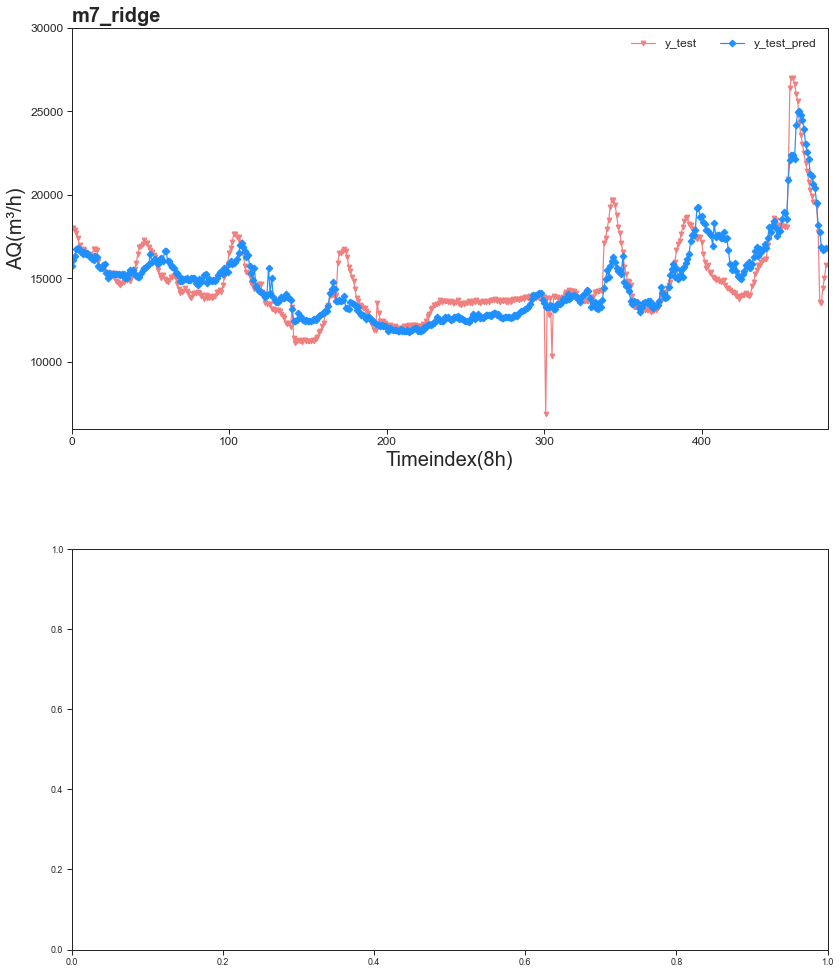

In [30]:
import seaborn as sns
sns.set(context='paper', style='ticks')

fig,axes=plt.subplots(2,1,figsize=(15,16))
ax1=axes[0]
ax2=axes[1]
fig.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)


x=test_index
y1=y_test['AQ']
y2=y_test_pred['AQ']
lns1=ax1.plot(x,y1,label='y_test',marker='v',markevery=1, color='lightcoral')
lns2=ax1.plot(x,y2,label='y_test_pred',marker='D',markevery=1, color='dodgerblue')
ax1.tick_params(labelsize=12)
ax1.set_xlim(0,480,1)
ax1.set_ylim(6000,30000, 2000)
ax1.set_xlabel('Timeindex(8h)',size=20)
ax1.set_ylabel('AQ(m³/h)',size=20)
ax1.set_title('m7_ridge',size=20,fontweight='bold',loc='left')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1,fontsize=12,ncol=2,frameon=False)

In [31]:
# plt.figure(figsize=(15,8))
# ax=plt.axes()
# plt_x=test['time'].to_numpy()
#     # .to_datetime().apply(lambda x: x.strftime('%Y-%m-%d'))
# print(type(plt_x))
# plt_y1=test[Y_columns].to_numpy()
# print(type(plt_y1))
# plt_y2=predictions
# print(type(plt_y2))
#
# plt.ylim(0, 30000)
# ax.plot(plt_x, plt_y1,color='r', marker='*', linestyle = '-.', lw=2, label='true') #‘s’ : 方块状
# ax.plot(plt_x, plt_y2,color='g', marker='o', linestyle = '-.', lw=2, label='predictions')

In [34]:
frame=pd.DataFrame()
frame['ytest']=y_test_pred
frame.to_excel('../secondgoaldata/m9_LGBM.xlsx')